# ParkMagic! 
### An Example Student Final Project for IST256

### By Michael Fudge

- Students are asked to create something useful with what they learned in the course
- This is usually some kind of data storytelling / app prototype / or both!
- See bottom of document as for why this is an "A" level project.

## Syracuse Park magic

- Will you get a parking ticket? We hope not!
- Data courtsey of Syracuse Open Data (https://data.syr.gov/)

## New Stuff I Learned on my own:

- Using the seaborn library for plots: https://seaborn.pydata.org/
- Haversine for distance calculations: https://pypi.org/project/haversine/
- Folium Custom Icons https://ocefpaf.github.io/python4oceanographers/blog/2015/11/02/icons/
- Custom Data set from Syracuse Open Data Portal

## Analysis

### Inputs

Enter a location, day and time (hour) you want to park

### Outputs

I will let you know your chances of getting a ticket (based on the data) and show tickets within a block or so of the location.

That way you can decide if you should pay for parking or not!

### Algorithms

Creating the final dataset

1. Load in the Syracuse Parking data
2. figure out the day of the week / hour of the day for the ticket
3. geocode the location to a lat/lon so it can be mapped
4. save the dataset


Calculating the probabilities

1. for the finalized dataset:
2. create a table of probabilities of getting a parking ticket on day of week X
3. do the same for hour of the day 


Main Alogirithm

1. load final dataset
2. get probabilities for day and hour from dataset
3. get inputs: location, day of week, and hour of day
4. geocode the input location, place it on the map
5. determine if input day is > average for that day
6. determine if input hour is > average for that hour
7. find parking tickets within a block (0.1 of a mile)
8. display chances of getting a ticket
9. display the map of parking tickets

In [1]:
%pip install -q haversine

Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display, HTML, Image
from ipywidgets import interact_manual
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
from time import sleep
import seaborn as sns
import folium
from haversine import haversine, Unit


# Part I: Exploratory Data Analysis

The purpose of an exploratory data analysis is to:

- Figure out "what you have"
- Understand how it can be used to tell a story
- Determine what is compelling to share as part of your story
- Build and enrich the dataset as needed to tell a better story.

The Titanic Lab from lesson 10 is an example of an exploratory data analysis.

## Explore the Data, Creating A Final Dataset

This section generates the final dataset `final_cuse_parking_violations.csv` from the source data `Parking_Violations_2023.csv` which was downloaded from the Syracuse Open Data Portal (https://data.syr.gov/) 

It does this after exploring the data for meaningful insights that will be included in the data story.

In [3]:
# read in the parking violations original dataset
pv = pd.read_csv("Parking_Violations_2023.csv")

In [4]:
pv.sample(10)

,X,Y,OBJECTID,ticket_number,issued_date,location,description,status,amount
5954,NaN,NaN,5955,371219D,2023/01/26 09:51:00+00,300 NORTH AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Adjudication Pending,60
14548,NaN,NaN,14549,230901048,2023/03/20 09:40:00+00,400 HICKORY ST,UNREGSTRD/UNAFFIXD/ALL VTL401-1/403-1,Paid In Full,25
7110,NaN,NaN,7111,395492D,2023/02/01 21:09:00+00,900 ELIZABETH BLACKWELL ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60
13311,-8.477231e+06,5.318645e+06,13312,349351D,2023/03/06 13:29:00+00,500 SALINA ST S,NO STPNG HERE TO CNR/ALL CO15-316(A)6,Second Notice,25
4052,NaN,NaN,4053,389134D,2023/01/23 00:45:00+00,300 JASPER ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60
2859,NaN,NaN,2860,230700408,2023/01/20 09:31:00+00,100 COMSTOCK AVE,OBSTRUCTING TRAFFIC/ALL CO15-317,Paid In Full,60
5382,NaN,NaN,5383,231500694,2023/01/31 10:51:00+00,100 CLARENDON ST,UNREGSTRD/UNAFFIXD/ALL VTL401-1/403-1,Paid In Full,25
8009,-8.480831e+06,5.320198e+06,8010,408136D,2023/02/10 09:43:00+00,1900 FAYETTE ST E,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Adjudication Pending,60
5894,NaN,NaN,5895,393049D,2023/01/24 19:35:00+00,1000 ADAMS ST E,NO STOPPING ANY TIME CO15-316 (A)14,Fourth Notice,25
7529,-8.475378e+06,5.320349e+06,7530,396404D,2023/02/04 23:54:00+00,300 GERTRUDE ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60


### Demonstrating What You Learned, While showing you can learn on your own!

These functions help enrich the data set the first one will extract the day of the week from the date, the second will exctract the hour of the day from the time. 

Why these? After exploring the data, I determined it would be interesting to investigate if more parking tickets are given out on a specific day of the week or time of day.

In [5]:
from datetime import datetime
def get_day_of_week(datestring):
    '''
    This function returns the day of the week (Monday, Tuesday, etc..) 
    for an input date string in the format:
    YYYY/MM/DD HH:MM:SS+00
    '''
    dow = datetime.strptime(datestring, "%Y/%m/%d %H:%M:%S+00").strftime("%A")
    return dow

assert get_day_of_week("2023/11/27 14:30:00+00")  == "Monday"

In [6]:
def get_hour_of_day(datestring):
    '''
    This function returns the hour of the day (01, 23, etc..) 
    for an input date string in the format:
    YYYY/MM/DD HH:MM:SS+00
    '''    
    hod = datetime.strptime(datestring, "%Y/%m/%d %H:%M:%S+00").strftime("%H")
    return hod

assert get_hour_of_day("2023/11/27 14:30:00+00") == "14"

use pandas `apply()` to generate a new column...

In [7]:
# Engineer dayofweek and hourofday columns we will need
pv['dayofweek'] = pv['issued_date'].apply(lambda dt: get_day_of_week(dt))
pv['hour'] = pv['issued_date'].apply(lambda dt: get_hour_of_day(dt))

In [8]:
pv.sample(10)

,X,Y,OBJECTID,ticket_number,issued_date,location,description,status,amount,dayofweek,hour
9716,NaN,NaN,9717,230100612,2023/02/23 09:42:00+00,300 WAVERLY AVE,NO STOPPING ANY TIME CO15-316 (A)14,Adjudication Pending,25,Thursday,09
6103,NaN,NaN,6104,231300653,2023/02/06 10:27:00+00,1800 BUTTERNUT ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Issued,60,Monday,10
8850,NaN,NaN,8851,230100479,2023/02/16 10:21:00+00,200 STATE ST S,PARKED ON SIDEWALK/ALL CO15-316 (A)1,Third Notice,60,Thursday,10
4273,-8.474522e+06,5.317471e+06,4274,23500454,2023/01/24 12:03:00+00,300 EUCLID AVE,NO PARKING ANY TIME CO15-316 (A)14,Fourth Notice,25,Tuesday,12
2352,NaN,NaN,2353,231500360,2023/01/14 18:47:00+00,900 MADISON ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60,Saturday,18
13626,-8.477009e+06,5.314101e+06,13627,410684D,2023/03/06 09:26:00+00,400 OSTRANDER AVE E,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Second Notice,60,Monday,09
12717,-8.473267e+06,5.322855e+06,12718,410628D,2023/03/02 11:10:00+00,300 VILLAGE DR,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Adjudication Pending,60,Thursday,11
7697,NaN,NaN,7698,394484D,2023/01/23 22:45:00+00,100 WHITTIER AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60,Monday,22
4780,NaN,NaN,4781,231500653,2023/01/26 10:56:00+00,200 CLINTON ST N,PARKED IN LOADING ZONE/ALL CO15-329,Paid In Full,25,Thursday,10
9148,NaN,NaN,9149,387245D,2023/02/13 08:04:00+00,200 BANK ALLEY,NO STOPPING ANY TIME CO15-316 (A)14,Paid In Full,25,Monday,08


In [9]:
cache = {
    '1000 EILEEN COLLINS BLVD SYRACUSE, NY' : (43.113505702811246,-76.11989651004016)
}

In [10]:
def geocode_syracuse(location):
    '''
    This will geocode the location. It uses a caching strategy
    so that we don't keep geocoding the same addresses.
    '''
    global cache
    location = f"{location} SYRACUSE, NY".upper()
    lat, lon = cache.get(location, (0, 0))
    if lat == 0 and lon == 0:
        sleep(0.5) # to avoid an error when geocoding to quickly
        query_string = {'q': location, 'format': 'json'}
        headers = {"user-agent": "ist256 example mafudge"}
        url = 'https://nominatim.openstreetmap.org/search'
        response = requests.get(url, params=query_string, headers=headers)
        response.raise_for_status()
        geodata = response.json()
        if geodata != []:
            lat, lon = geodata[0]['lat'], geodata[0]['lon']
            cache[location] = (lat, lon)
            return (lat, lon)
        else:
            return (0, 0)
    else:
        return (lat, lon)
# Testing with 2300 FAYETTE ST E syracuse, NY 
assert geocode_syracuse('2300 FAYETTE ST E') == ('43.048168', '-76.111425')

In [ ]:
# do the geocoding... this takes a while, so grab a drink while you wait!
pv['coords'] = pv.apply(lambda row: geocode_syracuse(row['location']), axis=1)

In [ ]:
pv.sample(10)

In [ ]:
# write out the final dataset
pv.to_csv("X_final_cuse_parking_violations.csv")

## Calculating the Probabilities

In this section I create tables for day of the week and hour of the day based on the probabilitity distributions of getting a ticket.

In [12]:
# read in the final dataset
pv = pd.read_csv("final_cuse_parking_violations.csv")

<Axes: xlabel='dayofweek', ylabel='count'>

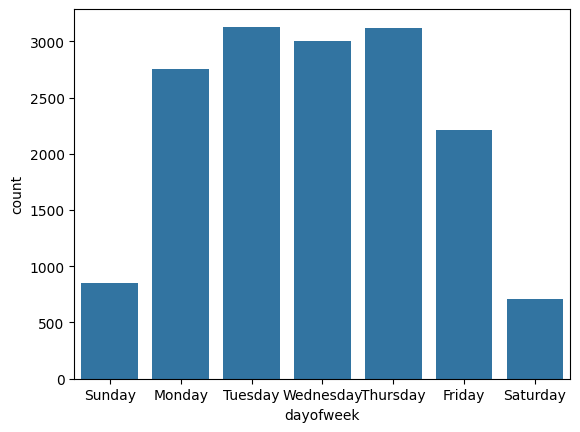

In [13]:
# checking out the days of the week. In a perfect scenaio all days would be equal. 1/7
# Not a lot of tickets on the weekend.
sns.countplot(x='dayofweek', data=pv)

In [14]:
day_prob_table = pv['dayofweek'].value_counts(normalize=True)
day_prob_table

dayofweek
Tuesday      0.198264
Thursday     0.197821
Wednesday    0.190473
Monday       0.174447
Friday       0.140369
Sunday       0.053968
Saturday     0.044657
Name: proportion, dtype: float64

<Axes: xlabel='hour', ylabel='count'>

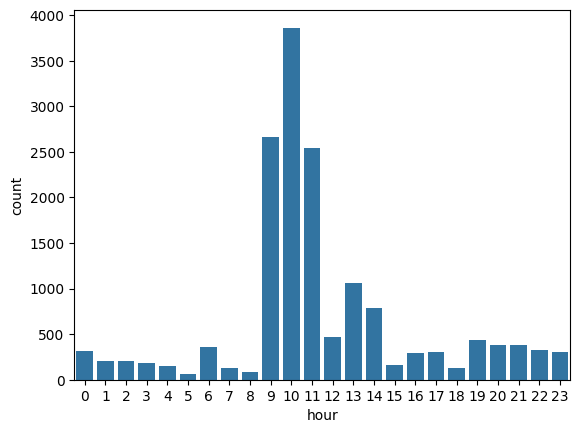

In [15]:
sns.countplot(x='hour', data=pv.sort_values("hour")) # Yuck let's sort it
# 9 - 11 am is ticket witching hour
# in a perfect scenairo all hours would be equal 1/24

In [16]:
hour_prob_table = pv['hour'].value_counts(normalize=True).sort_index()
hour_prob_table

hour
0     0.020143
1     0.013302
2     0.012922
3     0.011275
4     0.009755
5     0.003991
6     0.022677
7     0.008045
8     0.005701
9     0.168810
10    0.244632
11    0.160702
12    0.029645
13    0.067017
14    0.049661
15    0.010515
16    0.018243
17    0.019320
18    0.008171
19    0.027301
20    0.024324
21    0.024070
22    0.020460
23    0.019320
Name: proportion, dtype: float64

In [17]:
# example: retrieving a probability
hour = "02"
day = "Tuesday"
hour_prob_table[int(hour)], day_prob_table[day]

(0.012922024450497244, 0.19826439475517832)

# Part II - This is the Data Story Telling

## Main Program

Run the cells below this line to execute the main program. This will execute the code necessary to tell the data story. 

It assumes the `final_cuse_parking_violations.csv` exists already.

This should run on a new kernel provided `haversine` was installed.

In [18]:
from IPython.display import display, HTML, Image
from ipywidgets import interact_manual
import folium
import pandas as pd
import requests
from haversine import haversine, Unit

In [19]:
def geocode_syracuse_no_cache(location):
    '''
    This will geocode the location. It does not use a caching strategy
    '''
    location = f"{location} SYRACUSE, NY".upper()
    query_string = {'q': location, 'format': 'json'}
    headers = {"user-agent": "ist256 example mafudge"}
    url = 'https://nominatim.openstreetmap.org/search'
    response = requests.get(url, params=query_string, headers=headers)
    response.raise_for_status()
    geodata = response.json()
    if geodata != []:
        lat, lon = geodata[0]['lat'], geodata[0]['lon']
        return (lat, lon)
    else:
        return (0, 0)

assert geocode_syracuse_no_cache("330 W GENESEE ST") == ('43.05230228571428', '-76.15564457142858')

In [20]:
def mark_tickets_nearby(center_latlon, day, hour, pv, radius_in_miles):
    '''
    return a list of markers that are near center_latlon based on 
    radius_in_miles. was written to simplify the logic in the final program
    '''
    markers = []
    center_lat = float(center_latlon[0])
    center_lon = float(center_latlon[1])
    for index, row in pv[:].iterrows():
        lat = float(row['coords'].split(",")[0].replace("(","").replace("'","")) # clean up the lat which was a string
        lon = float(row['coords'].split(",")[1].replace(")","").replace("'","")) # # clean up the lon which was a string
        distance = haversine((center_lat, center_lon), (lat, lon), unit = Unit.MILES)
        if distance <= radius_in_miles:
            if day ==  row['dayofweek'] and hour == row['hour']:
                icon = icon=folium.Icon(color="red", icon="arrow-up")
            else:
                icon = icon=folium.Icon(color="orange", icon="arrow-up")

            text = f"{row['location']} - {row['dayofweek']} @ {row['hour']}:00 - {row['description']}"
            marker = folium.Marker(location=(lat, lon), popup = text, icon = icon)
            markers.append(marker)

    return markers

pv = pd.read_csv("final_cuse_parking_violations.csv")
lat, lon = geocode_syracuse_no_cache("330 W GENESEE ST")
assert len(mark_tickets_nearby((lat,lon), "Sunday", "09", pv, 0.05)) == 15

In [21]:
# Main Program
pv = pd.read_csv("final_cuse_parking_violations.csv")
day_prob_table = pv['dayofweek'].value_counts(normalize=True)
hour_prob_table = pv['hour'].value_counts(normalize=True).sort_index()
day_average = 1/7
hour_average = 1/24
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = hour_prob_table.index.values
metered_parking_day_exception = ['Sunday']
metered_parking_hour_exception = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '19', '20', '21', '22', '23', '24']

display(HTML("<h1>Syracuse Parkmagic</h1>"))
display(HTML("Let us help you avoid a parking ticket!"))
display(HTML("Enter the day, hour and address of where you want to mark and we will do the rest!"))

@interact_manual(day=days, hour=hours, address="330 E WASHINGTON ST")
def onclick(day, hour, address):
    day_prob = day_prob_table[day]
    hour_prob = hour_prob_table[int(hour)]
    lat, lon = geocode_syracuse_no_cache(address)
    cusemap = folium.Map(location=(lat,lon), zoom_start=18)
    marker = folium.Marker(location=(lat, lon), popup=address, icon=folium.Icon(color="green", icon="home"))
    cusemap.add_child(marker, name=address)
    if day_prob > day_average:
        day_interval = "HIGHER"
    else:
        day_interval = "LOWER"
    if hour_prob > hour_average:
        hour_interval = "HIGHER"
    else:
        hour_interval = "LOWER"
    if hour in metered_parking_hour_exception or day in metered_parking_day_exception:
        meter = "You do NOT need to pay for metered parking."
    else:
        meter = "You must pay at a parking meter."

    display(HTML("<h3>Parking Analysis</h3>"))
    display(HTML(f"Report for {address} On {day} at {hour}:00"))
    display(HTML(f"<li>{100*day_prob:.1f}% of all tickets were issued on this day. This is {day_interval} than the average."))
    display(HTML(f"<li>{100*hour_prob:.1f}% of all tickets were issued at your selected hour. This is {hour_interval} than the average."))
    display(HTML(f"<li>{meter}"))

    display(HTML("<h4>Past Tickets Issued in This Area</h4>"))
    markers = mark_tickets_nearby((lat,lon),day, hour, pv, 0.1)
    for marker in markers:
        cusemap.add_child(marker)
    display(cusemap)


interactive(children=(Dropdown(description='day', options=('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursd…

# What makes this an "A-Level" grade?

- Uses what we learned in units 09-13:
    - pandas, 
    - input and display widgets, 
    - visualizizations like maps / graphs
- Dataset is enriched in several ways:
    - geocode address to lat/lon
    - haversine distance for nearby tickets
    - day of week and time of day extracted from date and time
- I used something I had to figure out on my own (haversine)
- Code:
    - Clearly documented, labeled, 
    - Modularized into functions like `mark_tickets_nearby()`, and `get_day_of_week()`
    - Tests written for functions
    - Meets minimum line number requirements.
    - Any code that does something questionable is commented for clarity.
- Data Exploration
    - There is code that explores the data to figure out what kind of story I want to tell and why
    - Visuals such as charts, graphs, etc. were used to see what is happening with the data.
- Data Product
    - There is code that tells the story and allows a user to interact with the data product.
    - There is a completed problem analysis with inputs -> process -> output for the data product to explain how the story goes.
    - Missing are a video of my telling the data story + a reflection video for what I learned.